In [1]:
import abc
import copy
from collections import *
import random
from typing import *

import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
"""
Tic Tac Toe implementation
"""

EMPTY = 0
CROSS = 1
CIRCLE = -1

Move = Tuple[int, int]
PlayerId = int
Reward = float

COORDINATES = [
    (1, 1),                             # Middle first
    (0, 0), (2, 0), (0, 2), (2, 2),     # Corners
    (1, 0), (0, 1), (1, 2), (2, 1)      # The rest
]

COMBINATIONS = [
    # diagonals
    {(0, 0), (1, 1), (2, 2)},
    {(2, 0), (1, 1), (0, 2)},
    # rows
    {(0, 0), (0, 1), (0, 2)},
    {(1, 0), (1, 1), (1, 2)},
    {(2, 0), (2, 1), (2, 2)},
    # cols
    {(0, 0), (1, 0), (2, 0)},
    {(0, 1), (1, 1), (2, 1)},
    {(0, 2), (1, 2), (2, 2)}
]

def next_player(player: PlayerId):
    if player == CROSS:
        return CIRCLE
    return CROSS

class TicTacToe:
    def __init__(self, grid):
        self.grid = grid
    
    @classmethod
    def empty(cls):
        return cls(grid=np.zeros(shape=(3, 3)))
    
    def clone(self):
        return TicTacToe(grid=self.grid.copy())
    
    def __eq__(self, other):
        return np.array_equal(self.grid, other.grid)
    
    def __hash__(self):
        return hash(self.grid.tostring())

    def available_moves(self):
        moves = []
        for move in COORDINATES:
            if self.grid[move] == EMPTY:
                moves.append(move)
        return moves
    
    def play(self, player: PlayerId, move: Move) -> Reward:
        if self.grid[move] != EMPTY:
            raise Exception("Invalid move: " + str(move) + "for grid" + str(self.grid))
        
        self.grid[move] = player
        winner = self.winner()
        if winner == player:
            return 1
        elif winner == next_player(player):
            return -1
        return 0
    
    def is_over(self) -> bool:
        return self.filled() or self.winner() != EMPTY
    
    def winner(self):
        for combi in COMBINATIONS:
            cross_count = 0
            circle_count = 0
            for position in combi:
                if self.grid[position] == CROSS:
                    cross_count += 1
                elif self.grid[position] == CIRCLE:
                    circle_count += 1
            if cross_count == 3:
                return CROSS
            elif circle_count == 3:
                return CIRCLE
        return EMPTY
    
    def filled(self):
        for pos in COORDINATES:
            if self.grid[pos] == EMPTY:
                return False
        return True

In [3]:
"""
A famous way to win a game
x x o
    x
o   o
"""

game = TicTacToe.empty()
print(game.play(CROSS, (0, 0)))
print(game.play(CIRCLE, (2, 2)))
print(game.play(CROSS, (0, 1)))
print(game.play(CIRCLE, (0, 2)))
print(game.play(CROSS, (1, 2)))
print(game.play(CIRCLE, (2, 0)))
print(game.grid)
print(game.play(CROSS, (1, 1)))
print(game.play(CIRCLE, (2, 1)))
print(game.grid)
print("winner:", game.winner())

assert TicTacToe.empty() == TicTacToe.empty()
assert hash(TicTacToe.empty()) == hash(TicTacToe.empty())

0
0
0
0
0
0
[[ 1.  1. -1.]
 [ 0.  0.  1.]
 [-1.  0. -1.]]
0
1
[[ 1.  1. -1.]
 [ 0.  1.  1.]
 [-1. -1. -1.]]
winner: -1


In [4]:
"""
An environment for an agent to play against
"""


class Agent(abc.ABC):    
    @abc.abstractmethod
    def get_action(self, game: TicTacToe, player: PlayerId) -> Move:
        pass


class TicTacToeEnv:
    def __init__(self, opponent: Agent):
        self.game: TicTacToe = TicTacToe.empty()
        self.player = CROSS
        self.opponent = CIRCLE
        self.opponent_agent: Agent = opponent
        
    def reset(self):
        self.game = TicTacToe.empty()
        self.player = random.choice([CROSS, CIRCLE])
        self.opponent = next_player(self.player)
        if self.player == CIRCLE:  # Cross always start first
            move = self.opponent_agent.get_action(self.game, self.opponent)
            self.game.play(self.opponent, move)
        return self.state
    
    @property
    def state(self):
        return self.game.grid, self.player
    
    def is_over(self):
        return self.game.is_over()
    
    def step(self, move: Move) -> Reward:
        self.game = self.game.clone()
        reward = self.game.play(self.player, move)
        if self.game.is_over():
            return reward
        
        move = self.opponent_agent.get_action(self.game, self.opponent)
        reward = self.game.play(self.opponent, move)
        return -1 * reward

In [5]:
"""
Trying out the environment with another random agent
"""


class FirstMoveAgent(Agent):
    def get_action(self, game: TicTacToe, player: PlayerId) -> Move:
        return game.available_moves()[0]


class RandomAgent(Agent):
    def __init__(self):
        pass
    
    def get_action(self, game: TicTacToe, player: PlayerId) -> Move:
        moves = game.available_moves()
        return random.choice(moves)


def play_episode(env, agent, with_log=False):
    total_reward = 0.
    env.reset()
    while not env.is_over():
        if with_log:
            print(env.game.grid)
        move = agent.get_action(env.game, env.player)
        reward = env.step(move)
        total_reward += reward
    if with_log:
        print(env.game.grid)
    return total_reward, env.state


def try_out(env, agent):
    stats = defaultdict(int)
    counts = 1000
    for _ in range(counts):
        result, _ = play_episode(env, agent)
        stats[result] += 1    
    print("* win:", stats[1.0] / counts * 100, "%")
    print("* draw:", stats[0.0] / counts * 100, "%")
    print("* loss:", stats[-1.0] / counts * 100, "%")


print("Basic stats: first move (agent) vs random agent (env)")
try_out(env=TicTacToeEnv(opponent=RandomAgent()), agent=FirstMoveAgent())

Basic stats: first move (agent) vs random agent (env)
* win: 73.5 %
* draw: 5.0 %
* loss: 21.5 %


In [6]:
"""
All powerful agent: search throught he whole state space
"""


class AllKnowingAI(Agent):
    def __init__(self):
        self.memo = {}
    
    def get_action(self, game: TicTacToe, player: PlayerId) -> Move:
        return self._best_action(game, player)[0]

    def _best_action(self, game: TicTacToe, player: PlayerId) -> Tuple[Move, Reward]:
        if (game, player) in self.memo:
            return self.memo[(game, player)]

        if game.is_over():
            return None, 0.

        best_move = None
        best_score = -2.0
        for move in game.available_moves():
            next_game = game.clone()
            score = next_game.play(player, move)                
            _, next_score = self._best_action(next_game, next_player(player))
            score -= 0.9 * next_score  # negate the score of opponent + discount it to prefer early victories
            if score > best_score:
                best_score = score
                best_move = move

        self.memo[(game, player)] = best_move, best_score
        return best_move, best_score
        

"""
Trying this agent
"""

print("Basic stats: all knowing (agent) vs random agent (env)")
try_out(env=TicTacToeEnv(opponent=RandomAgent()), agent=AllKnowingAI())

print("Basic stats: all knowing (agent) vs all knowing (env)")
try_out(env=TicTacToeEnv(opponent=AllKnowingAI()), agent=AllKnowingAI())

Basic stats: all knowing (agent) vs random agent (env)
* win: 90.3 %
* draw: 9.700000000000001 %
* loss: 0.0 %
Basic stats: all knowing (agent) vs all knowing (env)
* win: 0.0 %
* draw: 100.0 %
* loss: 0.0 %


In [7]:
"""
Tabular Value Learning

There is a BIG PROBLEM HERE:
- We can easily learn the value function by observing, but...
- How would you PICK THE NEXT ACTION with the highest value (to select it)?
=> The only possibility would be to have a model of the environment (replicate the behavior of the agent inside the env)
"""

print("Harder than Q-Learning")

Harder than Q-Learning


In [8]:
"""
Tabular Afterstate Value Learning
"""

# TODO

'\nTabular Afterstate Value Learning\n'

In [9]:
"""
Tabular Q-Learning
"""


class QValues(Agent):
    def __init__(self):
        self.q_values = defaultdict(lambda: defaultdict(float))
    
    def __repr__(self):
        return repr(self.q_values)
    
    def get_action(self, game: TicTacToe, player: PlayerId) -> Move:
        best_move = None
        best_score = float('-inf')
        for move, score in self.q_values[(game, player)].items():
            if score > best_score:
                best_score = score
                best_move = move
        if best_move is None:
            best_move = random.choice(game.available_moves())
        return best_move
    
    def get_value(self, game: TicTacToe, player: PlayerId, move: Move) -> Reward:
        return self.q_values[(game, player)][move]
    
    def update_toward(self, game: TicTacToe, player: PlayerId, move: Move, target_value: Reward, learning_rate: float):
        self.q_values[(game, player)][move] += learning_rate * (target_value - self.q_values[(game, player)][move])
        # or alternatively:
        # self.q_values[(game, player)][move] = current_value * (1 - learning_rate) + learning_rate * target_value

        
"""
Q-Learning
"""

        
def q_learning(
    q_values: QValues, env: TicTacToeEnv, episodes: int,
    discount: float, learning_rate: float,
    epsilon: float, min_epsilon: float, epsilon_decrease: float):

    episode_rewards = []
    targets = []
    epsilons = []

    for _ in trange(episodes):
        env.reset()

        total_reward = 0.        
        while not env.is_over():
            game = env.game
            if np.random.rand(1) < epsilon:
                move = random.choice(game.available_moves())
            else:
                move = q_values.get_action(game, env.player)                        
            reward = env.step(move)
            total_reward += reward

            next_game = env.game
            if next_game.is_over():
                if env.game.winner() == env.player:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = reward
            else:
                next_move = q_values.get_action(next_game, env.player)
                next_value = q_values.get_value(next_game, env.player, next_move)
                target_value = reward + discount * next_value

            targets.append(target_value)
            q_values.update_toward(game, env.player, move, target_value, learning_rate)

        episode_rewards.append(total_reward)
        epsilons.append(epsilon)

    # Reporting
    fig, ax = plt.subplots(figsize=(15, 10), nrows=3)
    ax[0].plot(episode_rewards, label="rewards")
    ax[0].plot(pd.Series(episode_rewards).rolling(50).mean(), label="mean rewards")
    ax[1].plot(epsilons, label="epsilon")
    ax[2].plot(targets, label="targets")
    for p in ax:
        p.legend()
    plt.show()
    
    
"""
N-step Q-Learning
"""


def n_step_q_learning(
    q_values: QValues, env: TicTacToeEnv, episodes: int,
    discount: float, learning_rate: float,
    epsilon: float, min_epsilon: float, epsilon_decrease: float,
    step: int):

    episode_rewards = []

    for _ in trange(episodes):
        env.reset()

        total_reward = 0.
        memory = deque(maxlen=step)
        
        while not env.is_over():
            game = env.game
            if np.random.rand(1) < epsilon:
                move = random.choice(game.available_moves())
            else:
                move = q_values.get_action(game, env.player)                        
            reward = env.step(move)
            total_reward += reward
            
            memory.append((game, move, reward))

            next_game = env.game
            if next_game.is_over():
                if env.game.winner() == env.player:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = 0.
                for game, move, reward in reversed(memory):
                    target_value = reward + discount * target_value
                    q_values.update_toward(game, env.player, move, target_value, learning_rate)
                
            elif len(memory) == step:
                cum_discount = discount
                first_game, first_move, sum_reward = memory.popleft()
                for _, _, reward in memory:
                    sum_reward += cum_discount * reward
                    cum_discount *= discount
                next_move = q_values.get_action(next_game, env.player)
                next_value = q_values.get_value(next_game, env.player, next_move)
                target_value = sum_reward + discount * next_value
                q_values.update_toward(first_game, env.player, first_move, target_value, learning_rate)

        episode_rewards.append(total_reward)

    return episode_rewards


"""
With Double Q-Learning
"""


# TODO


"""
With planning
"""


# TODO

'\nWith planning\n'

100%|██████████| 50000/50000 [00:32<00:00, 1560.27it/s]


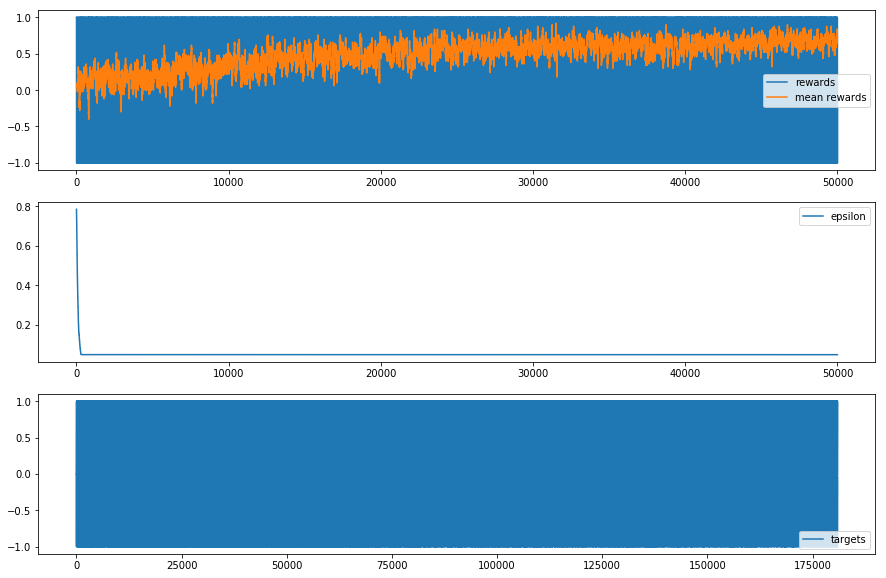

Efficiency at the end
defaultdict(<class 'int'>, {1.0: 809, -1.0: 93, 0.0: 98})


In [10]:
"""
Q-Learning against a random agent
"""


env=TicTacToeEnv(opponent=RandomAgent())

random.seed(1)
np.random.seed(1)
q_values = QValues()
q_learning(q_values, env, episodes=50_000, discount=0.99, learning_rate=0.02, epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98)

print("Efficiency at the end")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=q_values)
    stats[result] += 1
print(stats)

100%|██████████| 1000/1000 [00:00<00:00, 1086.67it/s]


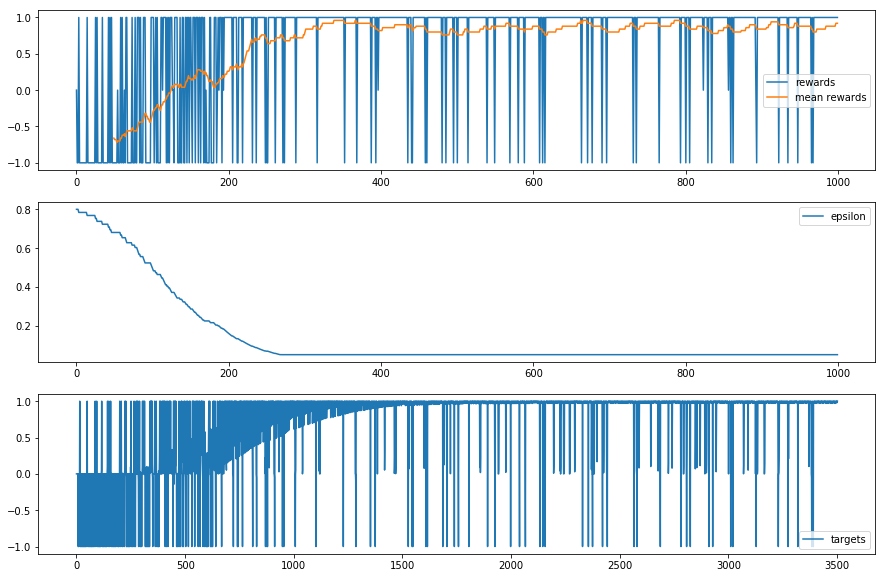

Efficiency at the end
defaultdict(<class 'int'>, {1.0: 1000})


In [11]:
"""
Q-Learning against a first move agent
"""


env=TicTacToeEnv(opponent=FirstMoveAgent())
q_values = QValues()

random.seed(1)
np.random.seed(1)
q_learning(q_values, env, episodes=1000, discount=0.99, learning_rate=0.05, epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98)


print("Efficiency at the end")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=q_values)
    stats[result] += 1
print(stats)

100%|██████████| 1000/1000 [00:00<00:00, 1214.56it/s]


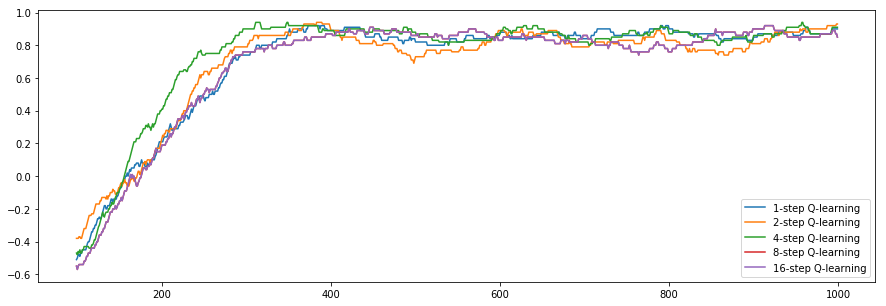

In [12]:
"""
Trying with different N-step values
"""


env=TicTacToeEnv(opponent=FirstMoveAgent())

all_rewards = []

for step in (1, 2, 4, 8, 16):
    q_values = QValues()
    random.seed(1)
    np.random.seed(1)
    episode_rewards = n_step_q_learning(
        q_values, env, episodes=1_000,
        discount=0.99, learning_rate=0.05,
        epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98,
        step=step)
    all_rewards.append((step, episode_rewards))
    
# Reporting
fig, ax = plt.subplots(figsize=(15, 5))
for step, episode_rewards in all_rewards:
    ax.plot(pd.Series(episode_rewards).rolling(100).mean(), label=str(step)+"-step Q-learning")
ax.legend()
plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 184.93it/s]


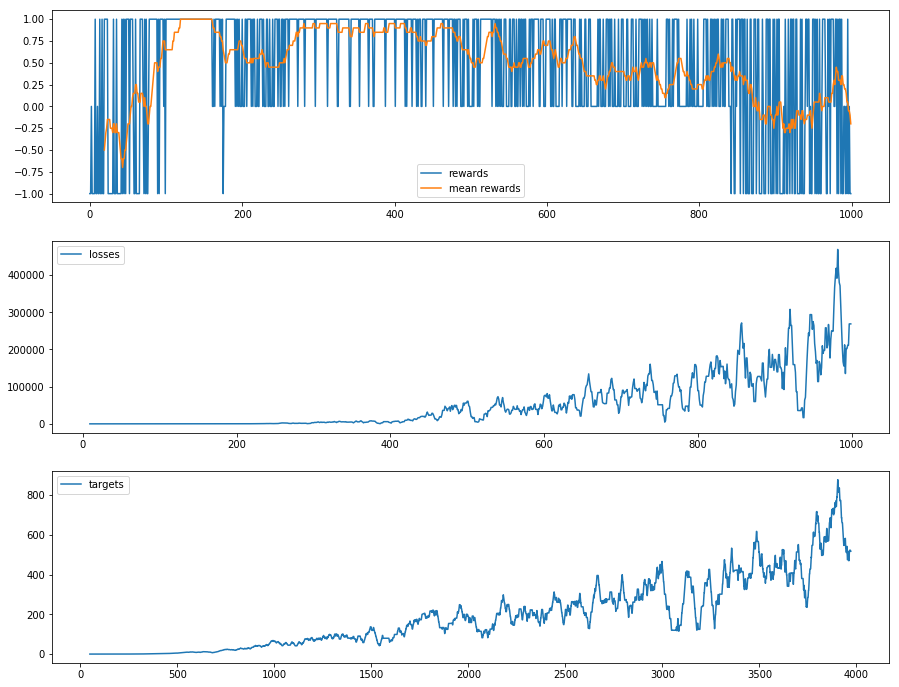

In [13]:
"""
Naive approximate Q-Learning, using Deep Learning techniques

Problems:
- the deadly triad (bootstrapping + appoximation + off-policy) is violated: the Q-values can diverge
- the positions are highly correlated to one-another
- the output of the policy is a single number that mixes 3 concepts: draw, win, loss probabilities
"""


class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=3*3+2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=9))
    
    def forward(self, grid: np.ndarray, player: PlayerId):
        xs = torch.FloatTensor(grid)
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, h * w))
        
        ys = torch.zeros(size=(batch_size, 2), dtype=torch.float32)
        if player == CROSS:
            ys[:,0] = 1
        else:
            ys[:,1] = 0
        
        xs = torch.cat((xs, ys), dim=-1)
        xs = self.fc(xs)
        return xs

    def clone(self):
        cloned = Policy()
        cloned.load_state_dict(self.state_dict())
        return cloned


"""
Training loop
"""


def mask_invalid_actions(game: TicTacToe, action_values: torch.Tensor) -> torch.Tensor:
    action_probs = nn.Softmax(dim=-1)(action_values) # HACK - to move to positive values, and mask others
    available = set(game.available_moves())
    mask = torch.zeros(size=(1,9), dtype=torch.uint8)
    for i, move in enumerate(COORDINATES):
        if move in available:
            mask[(0, i)] = 1
    action_probs[~mask] = 0.
    return action_probs


def best_of_available_moves(game: TicTacToe, action_values: torch.Tensor) -> Move:
    action_probs_masked = mask_invalid_actions(game, action_values)
    if action_probs_masked.sum() > 0: # TODO - sometimes, the probas are all zeros
        _, i = torch.max(action_probs_masked, dim=-1)
        return COORDINATES[i]
    else:
        return random.choice(game.available_moves())

    
def epsilon_greedy_action(policy, game, player: PlayerId, epsilon):
    # Epsilon greedy action
    # Note that it would not be correct to use a softmax on the Q-values
    # => you should go for policy gradient algorithms to do this
    if np.random.rand(1) < epsilon:
        return random.choice(game.available_moves())
    else:
        action_values = policy(game.grid, player)
        return best_of_available_moves(game, action_values)
    

def train_q_learning_policy(
    env, policy: nn.Module, episodes: int, discount: float,
    start_epsilon: float, min_epsilon: float, epsilon_decrease: float,
    learning_rate: float, learning_rate_decay: float,
    weight_decay: float):
    
    episode_rewards = []
    episode_losses = []
    target_values = []
    epsilon = start_epsilon

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_decay)

    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        env.reset()

        while not env.is_over():
            game = env.game
            move = epsilon_greedy_action(policy, game, env.player, epsilon)
            reward = env.step(move)
            
            # Get the target value
            next_game = env.game
            if next_game.is_over():
                if env.game.winner() == env.player:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = reward
            else:
                next_action_values = policy(next_game.grid, player=env.player)
                next_value, _ = torch.max(next_action_values, dim=-1)
                target_value = reward + discount * next_value.item()

            # Calculate loss & Update policy
            action_values = policy(game.grid, player=env.player).squeeze(dim=0)
            action_value = action_values[COORDINATES.index(move)]
            optimizer.zero_grad()
            loss = criterion(action_value, torch.tensor(target_value, dtype=torch.float32))
            loss.backward()
            optimizer.step()

            # Record history
            episode_reward += reward
            episode_loss += loss.item()
            target_values.append(target_value)
        
        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
    ax[0].plot(episode_rewards, label="rewards")
    ax[0].plot(pd.Series(episode_rewards).rolling(20).mean(), label="mean rewards")
    ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
    ax[2].plot(pd.Series(target_values).rolling(50).sum() / 100., label="targets")
    for p in ax:
        p.legend()
    plt.show()


env=TicTacToeEnv(opponent=FirstMoveAgent())

policy_1 = Policy()
train_q_learning_policy(
    env, policy=policy_1, episodes=1000, discount=0.99,
    start_epsilon=0.5, min_epsilon=0.0, epsilon_decrease=0.95,
    learning_rate=1e-3, learning_rate_decay=1.0,
    weight_decay=1e-3)

100%|██████████| 1000/1000 [00:03<00:00, 300.21it/s]


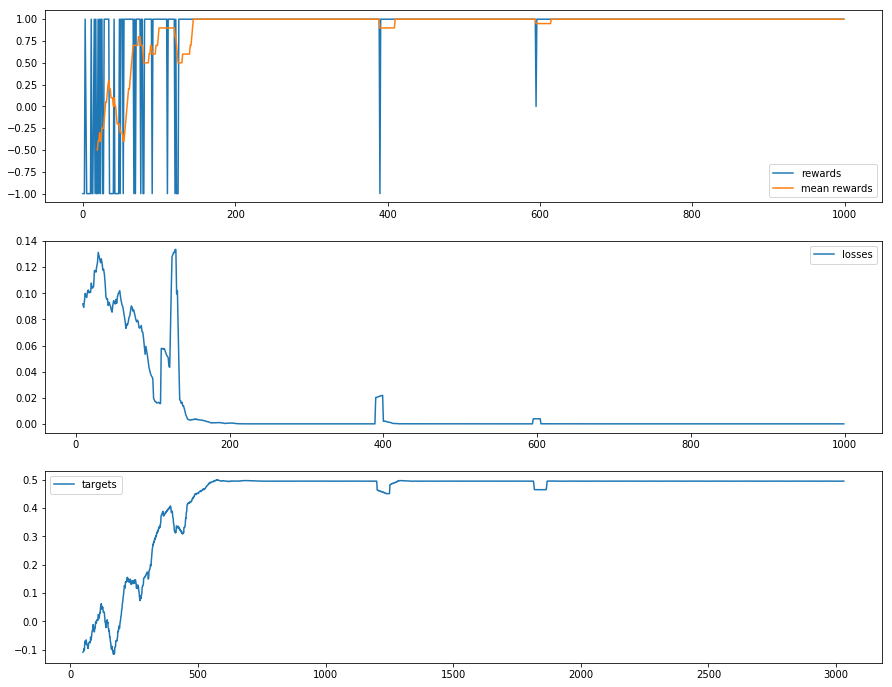

100%|██████████| 1000/1000 [00:04<00:00, 240.84it/s]


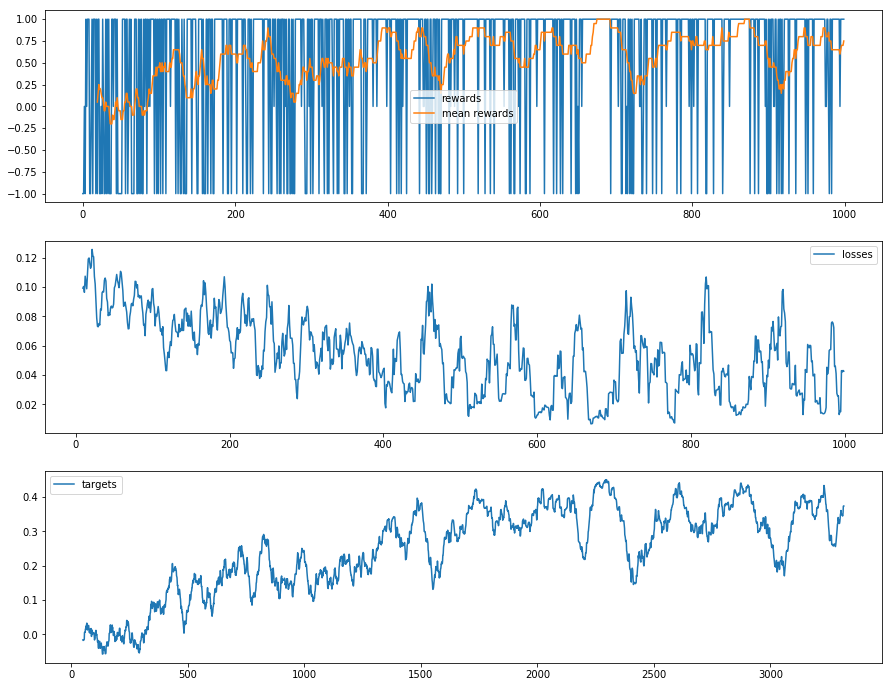

In [18]:
"""
Naive approximate SARSA, using Deep Learning techniques

Solved:
- the deadly triad (bootstrapping + appoximation + off-policy) is respected: the Q-values should converge 

Problems:
- the learned policy includes the epsilon (but we can reduce the epsilon)
- the positions are highly correlated to one-another
- the output of the policy is a single number that mixes 3 concepts: draw, win, loss probabilities
"""


class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=3*3+2, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=9))
    
    def forward(self, grid: np.ndarray, player: PlayerId):
        xs = torch.FloatTensor(grid)
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, h * w))
        
        ys = torch.zeros(size=(batch_size, 2), dtype=torch.float32)
        if player == CROSS:
            ys[:,0] = 1
        else:
            ys[:,1] = 0
        
        xs = torch.cat((xs, ys), dim=-1)
        xs = self.fc(xs)
        return xs
    
    def clone(self):
        cloned = Policy()
        cloned.load_state_dict(self.state_dict())
        return cloned


"""
Training loop
"""


def mask_invalid_actions(game: TicTacToe, action_values: torch.Tensor) -> torch.Tensor:
    action_probs = nn.Softmax(dim=-1)(action_values) # HACK - to move to positive values, and mask others
    available = set(game.available_moves())
    mask = torch.zeros(size=(1,9), dtype=torch.uint8)
    for i, move in enumerate(COORDINATES):
        if move in available:
            mask[(0, i)] = 1
    action_probs[~mask] = 0.
    return action_probs


def best_of_available_moves(game: TicTacToe, action_values: torch.Tensor) -> Move:
    action_probs_masked = mask_invalid_actions(game, action_values)
    if action_probs_masked.sum() > 0: # TODO - sometimes, the probas are all zeros
        _, i = torch.max(action_probs_masked, dim=-1)
        return COORDINATES[i]
    else:
        return random.choice(game.available_moves())

    
def epsilon_greedy_action(policy, game, player: PlayerId, epsilon) -> Tuple[Move, Reward]:
    # Epsilon greedy action
    # Note that it would not be correct to use a softmax on the Q-values
    # => you should go for policy gradient algorithms to do this
    action_values = policy(game.grid, player=player)
    if np.random.rand(1) < epsilon:
        move = random.choice(game.available_moves())
    else:
        move = best_of_available_moves(game, action_values)
    return move, action_values[(0, COORDINATES.index(move))]
    

def train_sarsa_policy(
    env, policy: nn.Module, episodes: int, discount: float,
    start_epsilon: float, min_epsilon: float, epsilon_decrease: float,
    learning_rate: float, learning_rate_decay: float,
    weight_decay: float, eligibility_fading: float):
    
    episode_rewards = []
    episode_losses = []
    target_values = []
    epsilon = start_epsilon

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_decay)

    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        env.reset()
        optimizer.zero_grad() # in case of eligibility traces
        move, move_value = epsilon_greedy_action(policy, env.game, env.player, epsilon)

        while not env.is_over():
            game = env.game
            reward = env.step(move)
            
            # Get the target value
            next_game = env.game
            if next_game.is_over():
                if env.game.winner() == env.player:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = reward
            else:
                next_move, next_move_value = epsilon_greedy_action(policy, next_game, env.player, epsilon)
                target_value = reward + discount * next_move_value.item()

            # Calculate loss & Update policy
            if eligibility_fading == 0.:
                optimizer.zero_grad()
            else:
                # TODO - why the "is not None" ???
                for param in policy.parameters():
                    if param.grad is not None:
                        param.grad *= eligibility_fading
            loss = criterion(move_value, torch.tensor(target_value, dtype=torch.float32))
            loss.backward()
            optimizer.step()

            # Record history
            episode_reward += reward
            episode_loss += loss.item()
            target_values.append(target_value)
            
            # Next iteration
            if not next_game.is_over():
                move = next_move
                move_value = next_move_value
        
        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
    ax[0].plot(episode_rewards, label="rewards")
    ax[0].plot(pd.Series(episode_rewards).rolling(20).mean(), label="mean rewards")
    ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
    ax[2].plot(pd.Series(target_values).rolling(50).sum() / 100., label="targets")
    for p in ax:
        p.legend()
    plt.show()
    
    
"""
Training against the first move agent
"""
    

env=TicTacToeEnv(opponent=FirstMoveAgent())

sarsa_policy_1 = Policy()
train_sarsa_policy(
    env, policy=sarsa_policy_1, episodes=1000, discount=0.99,
    start_epsilon=0.5, min_epsilon=0.001, epsilon_decrease=0.95,
    learning_rate=1e-3, learning_rate_decay=1.0,
    weight_decay=1e-3, eligibility_fading=0.0)


"""
Training against the random agent
"""
    

env=TicTacToeEnv(opponent=RandomAgent())

sarsa_policy_2 = Policy()
train_sarsa_policy(
    env, policy=sarsa_policy_2, episodes=1000, discount=0.99,
    start_epsilon=0.5, min_epsilon=0.001, epsilon_decrease=0.95,
    learning_rate=1e-3, learning_rate_decay=1.0,
    weight_decay=1e-3, eligibility_fading=0.0)

In [19]:
# TODO - this looks very suspicious


"""
Packaging the policy into an Agent
"""


class PolicyAgent(Agent):
    def __init__(self, policy: nn.Module):
        self.policy = policy
        self.policy.eval()

    def get_action(self, game: TicTacToe, player: PlayerId) -> Move:
        action_values = self.policy(game.grid, player=player)
        return best_of_available_moves(game, action_values)


"""
Trying the agent against various opponents
"""


print("Trained against first move:")

print("- Try against the first move agent:")
try_out(env=TicTacToeEnv(opponent=FirstMoveAgent()), agent=PolicyAgent(sarsa_policy_1))

print("- Try against the random move agent:")
try_out(env=TicTacToeEnv(opponent=RandomAgent()), agent=PolicyAgent(sarsa_policy_1))

print("Trained against random agent:")

print("- Try against the first move agent:")
try_out(env=TicTacToeEnv(opponent=FirstMoveAgent()), agent=PolicyAgent(sarsa_policy_2))

print("- Try against the random move agent:")
try_out(env=TicTacToeEnv(opponent=RandomAgent()), agent=PolicyAgent(sarsa_policy_2))


"""
Trying against each other
"""

print("Battle against each other:")
try_out(env=TicTacToeEnv(opponent=PolicyAgent(sarsa_policy_1)), agent=PolicyAgent(sarsa_policy_2))

Trained against first move:
- Try against the first move agent:
* win: 100.0 %
* draw: 0.0 %
* loss: 0.0 %
- Try against the random move agent:
* win: 64.2 %
* draw: 3.0 %
* loss: 32.800000000000004 %
Trained against random agent:
- Try against the first move agent:
* win: 48.199999999999996 %
* draw: 0.0 %
* loss: 51.800000000000004 %
- Try against the random move agent:
* win: 81.2 %
* draw: 7.5 %
* loss: 11.3 %
Battle against each other:
* win: 0.0 %
* draw: 0.0 %
* loss: 100.0 %


100%|██████████| 1000/1000 [00:05<00:00, 180.99it/s]


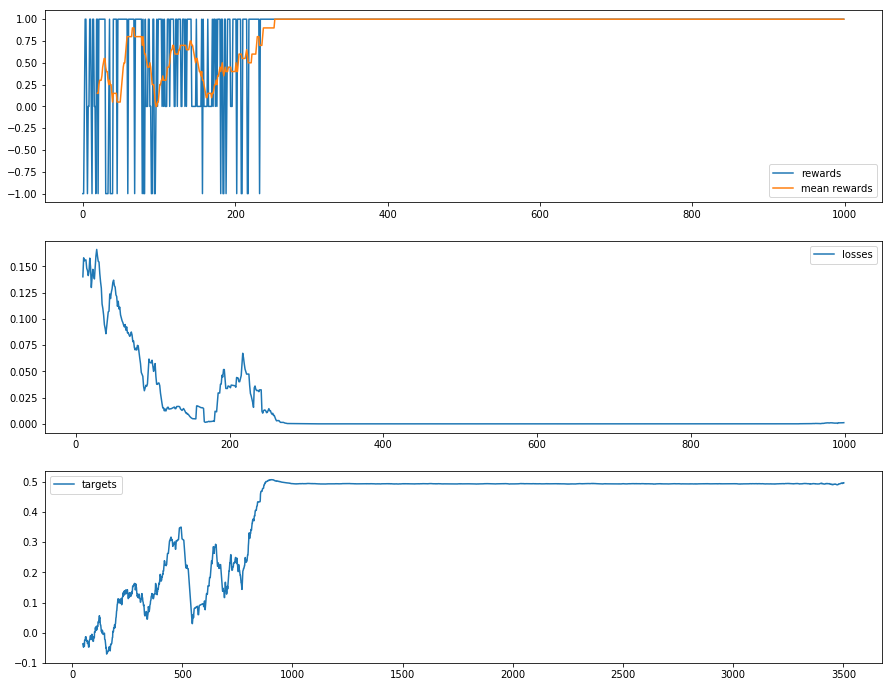

In [16]:
"""
Training against itself (run this several time if you need)
"""


# TODO - this cannot work, since there is no input for the player... both will try to help the first to win.


snapshot_1 = sarsa_policy_1.clone()
env=TicTacToeEnv(opponent=PolicyAgent(snapshot_1))

train_sarsa_policy(
    env, policy=sarsa_policy_1, episodes=1000, discount=0.99,
    start_epsilon=0.2, min_epsilon=0.001, epsilon_decrease=0.95,
    learning_rate=1e-3, learning_rate_decay=1.0,
    weight_decay=1e-3, eligibility_fading=0.0)